In [ ]:
import numpy as np
from numba import njit
import numba as nb

In [ ]:
@njit
def internal_mean(arr):
    '''
    same as np.mean(arr, axis=1), but jitted
    since numba does not support kwargs in np.mean
    '''
    assert len(arr.shape) == 3
    assert arr.shape[1] == 2

    out = np.zeros((arr.shape[0], arr.shape[2]), dtype=arr.dtype)
    for i, (v1, v2) in enumerate(arr):
        out[i] = (v1 + v2) / 2

    return out


In [ ]:
from rmsd import kabsch_rotate
from python_functions import rmsd_and_max
from algebra import internal_mean, vec_mean

@njit
def rmsd_and_max_jit(P, Q):
    '''
    ** ADAPTED FROM THE PYTHON RMSD LIBRARY **

    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Returns RMSD and max deviation.

    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    rmsd : float
        root-mean squared deviation
    max_delta : float
        maximum deviation value
    '''

    Q -= vec_mean(Q)
    P -= vec_mean(P)
    P = kabsch_rotate_jit(P, Q)

    diff = Q - P
    rmsd = np.sqrt((diff * diff).sum() / len(diff))
    max_delta = np.max(internal_mean(diff))

    return rmsd, max_delta

@njit
def kabsch_rotate_jit(P, Q):
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return np.dot(P, U)


In [ ]:
from algebra import internal_mean

x = np.random.rand(10, 100, 3)
a = np.mean(x, axis=1)
b = internal_mean(x)
np.allclose(a,b)

In [8]:
from cclib.io import ccread
data = ccread(r'C:\Users\ehrma\Desktop\cool_structs\Ph2PAla\Ph2PAla_confs_opt.xyz')
data.atomcoords.shape

(9, 50, 3)

In [16]:
r = [(i,rmsd_and_max(data.atomcoords[0], data.atomcoords[i])) for i in range(len(data.atomcoords))]
r

[(0, (1.8525749981896213e-15, 3.4967619351230766e-15)),
 (1, (1.9522309294727476, 4.349269692010169)),
 (2, (1.950567457203451, 4.293812257739693)),
 (3, (1.3926570564185698, 4.3814557682398325)),
 (4, (1.4772331398625664, 4.305962040648202)),
 (5, (2.8575661817906037, 6.973886368538465)),
 (6, (3.5039995314367505, 7.149551801218124)),
 (7, (3.496796142112092, 7.1505970015359175)),
 (8, (3.4875753074003564, 8.969396529698514))]

In [18]:
print(f'keep {len([i for i in r if i[1][0] < 2])}/{len(r)}')

keep 5/9


In [22]:
from algebra import get_inertia_moments
from pt import pt
masses = np.array([pt[i].mass for i in data.atomnos])
r = [(i,get_inertia_moments(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
r

[(0, array([2133.87886433, 4033.85175728, 4519.79219749])),
 (1, array([2108.10440921, 4100.0883652 , 4535.74187787])),
 (2, array([2133.75099027, 4017.2711705 , 4526.16978017])),
 (3, array([2082.10778038, 4160.35064935, 4540.05084272])),
 (4, array([2141.39031201, 3977.88204333, 4476.87732763])),
 (5, array([1902.57193096, 3745.32947845, 4970.9630804 ])),
 (6, array([1892.41180564, 3724.92135472, 4572.62959953])),
 (7, array([1909.48511256, 3702.47426642, 4564.52247149])),
 (8, array([1902.47378844, 3708.48279848, 4566.06758285]))]

In [29]:
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

[(0, 0.0),
 (1, 66.23660791267548),
 (2, 16.580586783055423),
 (3, 126.49889206717262),
 (4, 55.96971395089031),
 (5, 451.17088291074197),
 (6, 308.93040256764334),
 (7, 331.3774908658006),
 (8, 325.3689588073248)]

In [32]:
from algebra import center_of_mass
def MOI(coords, masses):
    coords -= center_of_mass(coords, masses)
    return np.sum([masses[i]*np.linalg.norm(coords[i])**2 for i in range(len(coords))])

MOI(data.atomcoords[0], masses)

5343.761409555133

In [33]:
r = [(i,MOI(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

[(0, 0.0),
 (1, 28.205916583229737),
 (2, 5.165439083692945),
 (3, 47.49322667178694),
 (4, 45.68656807037496),
 (5, 34.329164649966515),
 (6, 248.78002961179027),
 (7, 255.52048432172978),
 (8, 255.2493246734457)]

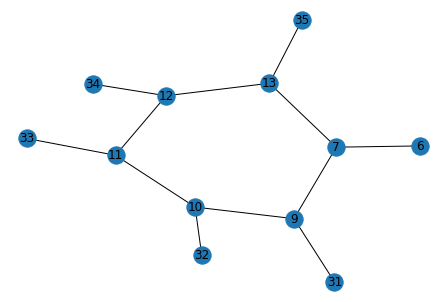

In [1]:
import networkx as nx
edges = [(7, 7), (7, 9), (7, 13), (7, 6), (9, 9), (9, 10), (9, 31), (10, 10), (10, 11), (10, 32), (11, 11), (11, 12), (11, 33), (12, 12), (12, 13), (12, 34), (13, 13), (13, 35), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True)

In [25]:
d = {}
for i in (31,32,33,34,35):
    d[i] = 1
for i in (7,9,10,11,12,13):
    d[i] = 6
d[6] = 15
d[345] = 45
nx.set_node_attributes(G, d, 'atomnos')
# G.nodes[6]['atomnos']
nx.get_node_attributes(G, 'atomnos')

{7: 6,
 9: 6,
 13: 6,
 6: 15,
 10: 6,
 31: 1,
 11: 6,
 32: 1,
 12: 6,
 33: 1,
 34: 1,
 35: 1}

In [3]:
import os
os.chdir(r'C:\Users\ehrma\Desktop\Coding\TSCoDe')
from graph_manipulations import get_sp_n
for node in G.nodes:
    print(f'{node}: sp{get_sp_n(node, G)}')

ValueError: list.remove(x): x not in list

In [1]:
from tscode.python_functions import prune_conformers, fast_score, rmsd_and_max
from tscode.optimization_methods import prune_enantiomers
from tscode.algebra import get_inertia_moments
from tscode.pt import pt
from cclib.io import ccread
import numpy as np
import networkx as nx
import numba as nb

def old(structures, atomnos):
    for k in (5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1):
        if k == 1 or 5*k < len(structures):
            structures, mask = prune_conformers(structures, atomnos, max_rmsd=2, max_delta=2, k=k)
    return structures, mask

def new(structures, atomnos):
    return new_prune_conformers(structures, atomnos, max_rmsd=2, max_delta=2)

def new_prune_conformers(structures, atomnos, max_rmsd=0.5, max_delta=None):
    '''
    Group structures into k subgroups and remove the similar ones.
    Similarity occurs for structures with both RMSD < max_rmsd and
    maximum deviation < max_delta.
    '''
    # xxx=0
    max_delta = max_rmsd * 2 if max_delta is None else max_delta

    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])

    cache_set = set()
    final_mask = np.ones(structures.shape[0], dtype=bool)
    
    for k in (5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1):
        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            d = len(structures) // k

            for step in range(k):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    l = len(range(d*step, num_active_str))
                else:
                    l = len(range(d*step, d*(step+1)))

                similarity_mat = np.zeros((l, l))

                for i_rel in range(l):
                    for j_rel in range(i_rel+1,l):

                        i_abs = i_rel+(d*step)
                        j_abs = j_rel+(d*step)

                        if (i_abs, j_abs) not in cache_set:
                        # if we have already performed the comparison,
                        # structures were not similar and we can skip them

                            rmsd, max_dev = rmsd_and_max(heavy_structures[i_abs],
                                                         heavy_structures[j_abs])

                            if rmsd < max_rmsd and max_dev < max_delta:
                                similarity_mat[i_rel,j_rel] = 1
                                break
                        # else:
                        #     xxx+=1

                for i_rel, j_rel in zip(*np.where(similarity_mat == False)):
                    i_abs = i_rel+(d*step)
                    j_abs = j_rel+(d*step)
                    cache_set.add((i_abs, j_abs))
                    # adding indexes of structures that are considered equal,
                    # so as not to repeat computing their RMSD
                    # Their index accounts for their position in the initial
                    # array (absolute index)

                matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [sorted(group, key=lambda i: fast_score(structures[i]))[0] for group in groups]
                # of each cluster, keep the structure that looks the best

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0
    # return xxx
    return structures[final_mask], final_mask

def new_prune_enantiomers(structures, atomnos, max_delta=10):
    '''
    Remove duplicate (enantiomeric) structures based on the
    moments of inertia on principal axes. If all three MOI
    are within max_delta from another structure, they are
    classified as enantiomers and therefore only one of them
    is kept.
    '''

    final_mask = np.ones(structures.shape[0], dtype=bool)
    heavy_structures = np.array([structure[atomnos != 1] for structure in structures])
    heavy_masses = np.array([pt[a].mass for a in atomnos if a != 1])
           
    for k in (5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1):
        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            d = len(structures) // k

            for step in range(k):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    structures_subset = heavy_structures[d*step:]
                else:
                    structures_subset = heavy_structures[d*step:d*(step+1)]

                similarity_mat = get_moi_similarity_matrix_new(structures_subset, heavy_masses, max_delta=max_delta)

                matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [sorted(group, key=lambda i: fast_score(structures[i]))[0] for group in groups]
                # of each cluster, keep the structure that looks the best

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0
                    
    return structures[final_mask], final_mask

@nb.njit
def get_moi_similarity_matrix_new(structures, masses, max_delta=10):
    ''''''
    l = len(structures)
    mat = np.zeros((l,l), dtype=nb.boolean)
    for i in range(l):
        im_i = get_inertia_moments(structures[i], masses)
        for j in range(i+1,l):
            im_j = get_inertia_moments(structures[j], masses)
            delta = np.abs(im_i - im_j)
            if np.all(delta < max_delta):
                mat[i,j] = 1
                break
    return mat

In [2]:
data = ccread(r'C:\Users\ehrma\Desktop\TMGA_peptides\P1_confs.xyz')
data.atomcoords.shape

(32, 102, 3)

In [4]:
n = 300

In [5]:
_, a = old(data.atomcoords[0:n], data.atomnos)
a.shape

(32,)

In [6]:
_, b = new(data.atomcoords[0:n], data.atomnos)
b.shape

(32,)

In [7]:
_, a = old(data.atomcoords[0:n], data.atomnos)
_, b = new(data.atomcoords[0:n], data.atomnos)
np.alltrue(a == b)

True

In [8]:
print(f'Kept {np.count_nonzero(b)}/{b.shape[0]}')

Kept 32/32


In [48]:
cached = new(data.atomcoords[0:n], data.atomnos)
print(f'Cached {cached}/{n*n}')

Cached 37934/90000


In [9]:
from tscode.algebra import get_moi_similarity_matrix
def prune_enantiomers_light(structures, atomnos, max_delta=10):
    '''
    Remove duplicate (enantiomeric) structures based on the
    moments of inertia on principal axes. If all three MOI
    are within max_delta from another structure, they are
    classified as enantiomers and therefore only one of them
    is kept.
    '''
    heavy_structures = np.array([structure[atomnos != 1] for structure in structures])
    heavy_masses = np.array([pt[a].mass for a in atomnos if a != 1])

    matches = get_moi_similarity_matrix(heavy_structures, heavy_masses, max_delta=max_delta)

    g = nx.Graph(matches)

    subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
    groups = [tuple(graph.nodes) for graph in subgraphs]

    best_of_cluster = [group[0] for group in groups]

    rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
    rejects = []
    for s in rejects_sets:
        for i in s:
            rejects.append(i)

    mask = np.ones(structures.shape[0], dtype=bool)
    for i in rejects:
        mask[i] = False

    return structures[mask], mask


In [18]:
n = 2500

In [8]:
%timeit prune_enantiomers(data.atomcoords[0:n], data.atomnos)

9.06 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit new_prune_enantiomers(data.atomcoords[0:n], data.atomnos)

11.5 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit prune_enantiomers_light(data.atomcoords[0:n], data.atomnos)

4.16 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
_ = prune_enantiomers(data.atomcoords[0:n], data.atomnos)

In [19]:
_ = prune_enantiomers_light(data.atomcoords[0:n], data.atomnos)

## Testing parallel augmentation/embedding

In [1]:
from tscode.embedder import Embedder

embedder = Embedder(r'C:\Users\Nik\Desktop\nt383\P1\debug\debug.txt')


             ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
            ╱───────────────────────────────────╲
           ╱▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒╲
       ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒
    ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒ 
   ▒░████████╗░██████╗░█████╗░░█████╗░██████╗░███████╗░░░▒
   ▒░╚══██╔══╝██╔════╝██╔══██╗██╔══██╗██╔══██╗██╔════╝░░░▒ 
   ▒░░░░██║░░░╚█████╗░██║░░╚═╝██║░░██║██║░░██║█████╗░░░░░▒  
   ▒░░░░██║░░░░╚═══██╗██║░░██╗██║░░██║██║░░██║██╔══╝░░░░░▒   
    ▒░░░██║░░░██████╔╝╚█████╔╝╚█████╔╝██████╔╝███████╗░░░▒    
   ╱ ▒░░╚═╝░░░╚═════╝░░╚════╝░░╚════╝░╚═════╝░╚══════╝░░▒ ╲
  ╱   ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒   ╲
 ╱    ▒░░╔══════════════════════════════════════════╗░░▒    ╲
 ╲╲    ▒░║  Transition State Conformational Docker  ║░▒    ╱╱   
  ╲╲   ▒░║        nicolo.tampellini@yale.edu        ║░▒   ╱╱    
   ╲╲  ▒░║                                          ║░▒  ╱╱         
    ╲╲ ▒░║     Version    >          0.1.1        

In [2]:
embedder.objects[0].atomcoords.shape

(1000, 102, 3)

In [3]:
from tscode.run import RunEmbedding
import numpy as np
embedder.structures = embedder.objects[0].atomcoords
embedder.atomnos = embedder.objects[0].atomnos
embedder.constrained_indexes = np.array([[] for _ in embedder.structures])

RE = RunEmbedding(embedder)
RE.options.rmsd = 0.5
RE.options
RE.ids

array([102])

In [4]:
from tscode.clustered_csearch import csearch
RE.structures = csearch(RE.structures[0], RE.atomnos, mode=2)
RE.constrained_indexes = np.array([RE.constrained_indexes[0] for _ in RE.structures])


> Torsion list: (indexes : n-fold)
 0 - (1, 2, 5, 6)          : 2-fold
 1 - (2, 3, 8, 9)          : 3-fold
 2 - (2, 5, 35, 7)         : 3-fold
 3 - (5, 35, 7, 15)        : 3-fold
 4 - (5, 35, 38, 39)       : 3-fold
 5 - (8, 9, 11, 12)        : 3-fold
 6 - (9, 11, 13, 36)       : 3-fold
 7 - (13, 37, 22, 23)      : 3-fold
 8 - (22, 24, 25, 26)      : 3-fold
 9 - (23, 22, 24, 25)      : 3-fold
 10 - (24, 22, 23, 31)      : 3-fold
 11 - (35, 38, 39, 40)      : 3-fold

> Rotable bonds ids: 2 3 5 7 8 9 11 13 22 23 24 25 35 37 38 39

--> Random dihedral CSearch on test
    mode 2 (random) - 12 torsions
  Generated 100 conformers, (0.03 % of the total conformational space (CSearch time 5.407 s)


In [5]:
RE.compenetration_refining()
RE.force_field_refining()

--> Checking structures for compenetrations
All structures passed the compenetration check


--> Checkpoint output - Wrote 100 TS structures to TSCoDe_checkpoint_Jun_21_22-28.xyz file before FF optimization.

--> Structure optimization (MMFF94 level via OB)
Optimizing structure 100/100  |##################################################| 100.0% 
Force Field MMFF94 optimization took 46.83 s (~0.468 s per structure)
Successfully optimized 97/100 candidates at MMFF94 level.
Discarded 3 candidates for energy (97 left, threshold 20 kcal/mol)
--> Checkpoint output - Updated 97 TS structures to TSCoDe_checkpoint_Jun_21_22-28.xyz file before MOPAC optimization.



In [6]:
checkpoint = RE.structures, RE.energies, RE.constrained_indexes

In [7]:
 
RE.csearch_augmentation()

--> Performing conformational augmentation of TS candidates 
Performing CSearch 97/97  |##################################################| 100.0% 
Conformational augmentation completed - generated 970 new conformers (1 m 54.984 s)



In [8]:
for cores in (1, 2, 4 ,8):
    RE.structures, RE.energies, RE.constrained_indexes = checkpoint
    RE.csearch_augmentation_parallel(max_ncores=cores)

--> Performing conformational augmentation of TS candidates (parallel on up to 1 cores)
Conformational augmentation completed - generated 970 new conformers (1 m 59.53 s)

--> Performing conformational augmentation of TS candidates (parallel on up to 2 cores)
Conformational augmentation completed - generated 970 new conformers (1 m 8.439 s)

--> Performing conformational augmentation of TS candidates (parallel on up to 4 cores)
Conformational augmentation completed - generated 970 new conformers (47.418 s)

--> Performing conformational augmentation of TS candidates (parallel on up to 8 cores)
Conformational augmentation completed - generated 970 new conformers (46.422 s)



In [9]:
# Simple R_hemiacetals
#  1 core = 12 s
#  2 core = 11 s
#  4 core = 14 s
#  8 core = 21 s

# P1 confs (100 confs)
#  1 core = 120 s
#  2 core = 68 s
#  4 core = 47 s
#  8 core = 46 s

# 4 - the physical cores - seems to be best

In [1]:
from tscode.embeds import string_embed, string_embed_parallel
from tscode.embedder import Embedder
embedder = Embedder(r'C:\Users\Nik\Desktop\nt383\P1\debug\fakeembed.txt')


             ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
            ╱───────────────────────────────────╲
           ╱▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒╲
       ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒
    ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒ 
   ▒░████████╗░██████╗░█████╗░░█████╗░██████╗░███████╗░░░▒
   ▒░╚══██╔══╝██╔════╝██╔══██╗██╔══██╗██╔══██╗██╔════╝░░░▒ 
   ▒░░░░██║░░░╚█████╗░██║░░╚═╝██║░░██║██║░░██║█████╗░░░░░▒  
   ▒░░░░██║░░░░╚═══██╗██║░░██╗██║░░██║██║░░██║██╔══╝░░░░░▒   
    ▒░░░██║░░░██████╔╝╚█████╔╝╚█████╔╝██████╔╝███████╗░░░▒    
   ╱ ▒░░╚═╝░░░╚═════╝░░╚════╝░░╚════╝░╚═════╝░╚══════╝░░▒ ╲
  ╱   ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒   ╲
 ╱    ▒░░╔══════════════════════════════════════════╗░░▒    ╲
 ╲╲    ▒░║  Transition State Conformational Docker  ║░▒    ╱╱   
  ╲╲   ▒░║        nicolo.tampellini@yale.edu        ║░▒   ╱╱    
   ╲╲  ▒░║                                          ║░▒  ╱╱         
    ╲╲ ▒░║     Version    >          0.1.1        

In [2]:
coords = embedder.objects[0].atomcoords[0:50]
embedder.objects[0].atomcoords = coords
embedder.objects[1].atomcoords = coords

In [3]:
poses = string_embed(embedder)


--> Performing string embed (36.0 M candidates)
Embedding structures  |##################################################| 100.0% (0 found)


ZeroCandidatesError: 
--> Cyclical embed did not find any suitable disposition of molecules.
    This is probably because the two molecules cannot find a correct interlocking pose.
    Try expanding the conformational space with the csearch> operator or see the SHRINK keyword.

In [3]:
embedder.options.procs = 4
poses = string_embed_parallel(embedder)


--> Performing string embed (36.0 M candidates, parallel on up to 4 cores)


In [ ]:
# P1 confs embed (50 confs)
#  1 core = 28 s
#  2 core =  s
#  4 core =  s
#  8 core =  s

### Why do all force field opt with gfn scramble?

In [1]:
from tscode.utils import read_xyz, scramble_check, graphize
import numpy as np

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\debug\TSCoDe_embedded_P1_lead.xyz')
data.atomcoords.shape

(1000, 147, 3)

In [2]:
m1 = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\debug\P1.xyz')
m2 = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\debug\Hemiacetals_Ph.xyz')
print(m1.atomcoords.shape)
m2.atomcoords.shape

(1, 102, 3)


(2, 45, 3)

In [4]:

ci = np.array([[39, 135]])
mg = [graphize(m1.atomcoords[0], m1.atomnos), graphize(m2.atomcoords[0], m2.atomnos)]

scramble_results = [scramble_check(s, data.atomnos, constrained_indexes=ci, mols_graphs=mg) for s in data.atomcoords]

In [5]:
np.count_nonzero(scramble_results)

1000

In [6]:
scramble_results[0:10]

[True, True, True, True, True, True, True, True, True, True]

## Looking through results

In [3]:
from tscode.utils import read_xyz
import numpy as np
from tscode.algebra import norm_of

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\TSCoDe_checkpoint_P1_lead.xyz')
data.atomcoords.shape

(601, 151, 3)

In [6]:
from tscode.clustered_csearch import _get_hydrogen_bonds
from tscode.utils import graphize

ids = [i for i, c in enumerate(data.atomcoords) if 121 in _get_hydrogen_bonds(c, data.atomnos, graphize(c, data.atomnos))]
len(ids)

0

In [ ]:
from tscode.utils import write_xyz

with open('recognized')

## New similarity criteria: torsion fingerprints